This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

In dividing and classifying the city names within the data-set, __[this article from the New York Times](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__ was instrumental as was __[this website](http://zakhor-online.com/?attachment_id=7932)__ and __[this one.](https://www.vox.com/a/maps-explain-the-middle-east)__
__[and this one too](http://gulf2000.columbia.edu/maps.shtml)__ https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8

In this notebook, we will try and isolate data related to cyber-warfare or hacking events.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### 1. Importing, Cleaning and General Overview:

#### A. Importing Data.

In [2]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AN, AP, BG, BM:BN, BQ:BR, CD:CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [3]:
# Renaming for usability:

cyber_data = pd.DataFrame(df.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended':'24+hrs', 'provstate':'region_2', 'doubtterr':'doubt', 
             'attacktype1':'attack_1', 'attacktype1_txt':'attack_1txt','attacktype2':'attack_2', 
             'targtype1':'target_1', 'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
             'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
             'natlty1':'victim_nationality', 'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
             'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 'weaptype1':'weapon', 
             'weaptype1_txt':'weapontxt', 'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

#### B. Selecting Rows Specific to Our Question (cyber_data):


In [4]:
# Creating the dyber_cyber_train_input Dataframe:
# Regex to isolate qualifying data (This set is more flexible in its Regex):
import re
import gc

print(cyber_data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

# Creating a mask which represents the results from our search above:

mask = cyber_data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Creating a new, filtered dataframe with this specific information:

cyber_data = pd.DataFrame(cyber_data[mask])

False    172205
True       9486
Name: summary, dtype: int64


#### C. Splitting Our Train/Test Data (cyber_train/test_X / cyber_train/test_Y):

In [5]:
from sklearn.model_selection import cross_val_score, train_test_split

In [6]:
# Defining our Input and Output:
# Cleaning later to prevent leakage.

X = cyber_data.drop(['event_id', 'success', 'summary', 'motive'], axis = 1)
Y = pd.DataFrame(cyber_data['success'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .5)

X_train_start_index = X_train.index
X_test_start_index = X_test.index

#### D. Isolating Columns:

> We want to be sure we are only using the numeric columns that are significant and not arbitrary categoricals:

In [7]:
# Dropping irrelevant columns from training set input and putting it into a datafarme:

cyber_train_X = X_train[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the training output column (i.e. making sure our input and output cyber_train_inputs
# have the same amount of rows):

# cyber_train_input_index = cyber_train_input.index same as X_train_start_index

cyber_train_Y = Y_train.iloc[Y_train.index == cyber_train_X.index]

In [8]:
# Applying the same process above to our test data:

cyber_test_X = X_test[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the testing output column (i.e. making sure our input and output cyber_test_inputs
# have the same amount of rows):

# cyber_test_input_index = cyber_test_input.index (same as X_test index)

cyber_test_Y = Y_test.iloc[Y_test.index == cyber_test_X.index]

In [9]:
cyber_train_X.shape

(4743, 19)

In [10]:
cyber_test_X.shape

(4743, 19)

#### E. Applying Filters to Text Columns.

> Doing this mainly in the hopes of allowing us to get dummies on certain features which is small enough to use for explanatory purposes (i.e. avoiding a feature set with thousands of columns).

##### Weapontxt:

> ###### Training Input:

In [11]:
# Grouping Biological and Chemical Weapons:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


> ###### Test Input:

In [12]:
# Grouping Biological and Chemical Weapons:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


##### Sub_targettxt:

> ###### Training Input:

In [13]:
industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protrainer', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'train/train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

> ###### Test Data:

In [14]:
# Test Data:

industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protester', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'test/test Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

##### Group_name:

> Trying Group_name a bit and grouping them by Ideaology.

> ###### Training Input:

In [15]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [16]:
# Asian Separatists:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [17]:
# Middle Eastern Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [18]:
# Indian Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [19]:
# African Political:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [20]:
# Irish Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Irish Republican Army (IRA)',
                                                        'rish_Separatists')


In [21]:
# Farc left and right
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [22]:
# Middle Eastern Religious:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [23]:
# Israeli, Palestinian, Lebanese Religious:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [24]:
# Asian and African Religious:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Boko Haram',
                                                        'African_Religious')


> ###### Test Input:

In [25]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [26]:
# Asian Separatists:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [27]:
# Middle Eastern Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [28]:
# Indian Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [29]:
# African Political:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [30]:
# Irish Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Irish Republican Army (IRA)',
                                                        'Irish_Separatists')


In [31]:
# Farc left and right
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [32]:
# Middle Eastern Religious:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [33]:
# Israeli, Palestinian, Lebanese Religious:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [34]:
# Asian and African Religious:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Boko Haram',
                                                        'African_Religious')


##### City:

> Trying City Names by Religion, Tribal Associations or Conflict Areas:

> ###### Training Input:

In [35]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [36]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [37]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [38]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [39]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [40]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [41]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [42]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [43]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


> ###### Test Input:

In [44]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [45]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [46]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [47]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [48]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [49]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [50]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [51]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [52]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_test_X['city'] = cyber_test_X['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


### 2. Preliminary Visualizations and Exploration:

> Taking a look to see what is happening:

#### A. Correlation:

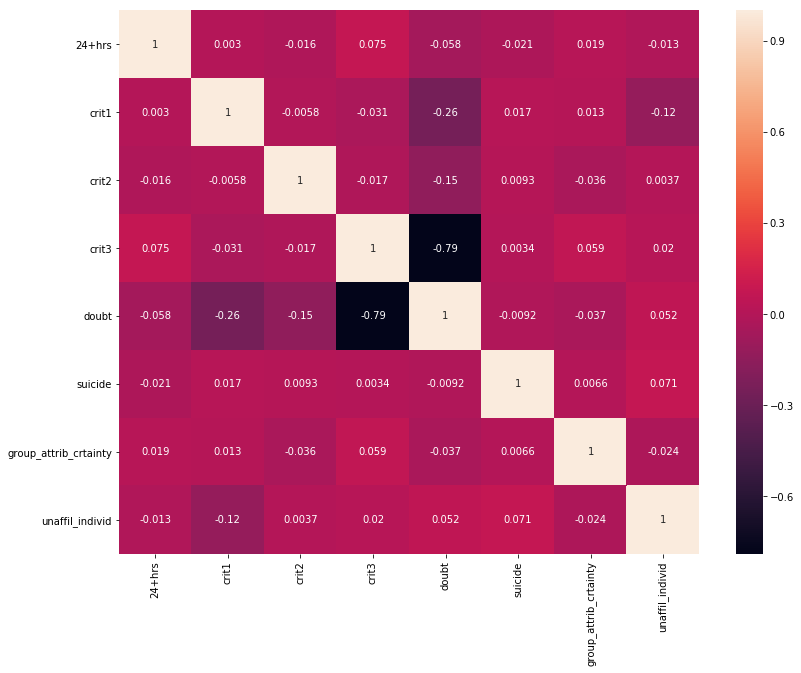

In [53]:
f, ax = plt.subplots(figsize = (13, 10))
sns.heatmap(cyber_train_X.corr(), annot = True)
plt.show()

### 3. Feature Selection:

> Getting closer to modeling and using feature selection algorithms to see what will help us best minimize our feature set while maintaining the most amount of variation in our dataset.

#### A. Select K-Best:

In [54]:
# Scouting out the null situation:

print(cyber_train_X.shape)
cyber_train_X.isna().sum()

(4743, 19)


24+hrs                     0
country_txt                0
region_txt                 0
city                      20
crit1                      0
crit2                      0
crit3                      0
doubt                      0
suicide                    0
attack_1txt                0
target_1txt                0
sub_targettxt            252
specific_target           10
victim_nationalitytxt     56
group_name                 0
group_attrib_crtainty     22
unaffil_individ            0
weapontxt                  0
sub_weapontxt            314
dtype: int64

In [55]:
print(cyber_test_X.shape)
cyber_test_X.isna().sum()

(4743, 19)


24+hrs                     0
country_txt                0
region_txt                 0
city                      26
crit1                      0
crit2                      0
crit3                      0
doubt                      0
suicide                    0
attack_1txt                0
target_1txt                0
sub_targettxt            229
specific_target            4
victim_nationalitytxt     58
group_name                 0
group_attrib_crtainty     25
unaffil_individ            0
weapontxt                  0
sub_weapontxt            357
dtype: int64

> Since the null values are relatively few, we will go ahead and drop them from the input dataframes.  This could be better than imputing the mode

##### Assessing Overall DF (cyber_train_dummy_X/Y & cyber_test_dummy_X/Y):

In [56]:
from sklearn import feature_selection

In [57]:
# Getting dummies or our input train and test data:

# cyber_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input.dropna(axis = 0)))
# train_dummy_index = cyber_train_dummy.index
# cyber_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
#                                                         lambda x: x in train_dummy_index)])

# cyber_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input.dropna(axis = 0)))
# test_dummy_index = cyber_test_dummy.index
# cyber_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
#                                                         lambda x: x in test_dummy_index)])

In [58]:
# Getting dummies on our training and test sets (slight wrangling involved):

cyber_train_X.dropna(axis = 0, inplace = True)
cyber_test_X.dropna(axis = 0, inplace = True)

train_index = cyber_train_X.index
test_index = cyber_test_X.index

dummy_prep = pd.concat([cyber_train_X, cyber_test_X])
dummy_1 = pd.get_dummies(dummy_prep)

# Training/Test Inputs:

cyber_train_dummy_X = dummy_1.loc[train_index]
cyber_test_dummy_X = dummy_1.loc[test_index]

# Training Output:

cyber_train_dummy_Y = cyber_train_Y.loc[train_index]
cyber_test_dummy_Y = cyber_test_Y.loc[test_index]

In [59]:
# Making sure we have the same sizes still:

print(cyber_train_dummy_X.shape)
print(cyber_test_dummy_X.shape)

(4139, 9222)
(4117, 9222)


In [219]:
# Fitting SelectKBest to our Features and output:

KBest_1 = feature_selection.SelectKBest(k = 500) # Had 30 previously
cyber_train_KBest1 = KBest_1.fit_transform(cyber_train_dummy_X, cyber_train_dummy_Y)

# Transforming the test-set

cyber_test_KBest1 = KBest_1.transform(cyber_test_dummy_X)

In [221]:
# Creating a DF with the top 30 features:

feature_mask = KBest_1.get_support(indices = True)
KBest_1_features = pd.DataFrame(cyber_train_dummy_X.columns[feature_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_1_features['P_Vals'] = KBest_1.pvalues_[0:500]
KBest_1_features['Scores'] = KBest_1.scores_[0:500]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_1_features

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,24+hrs,5.595263e-09,34.114541
1,crit3,3.822689e-01,0.763555
2,doubt,2.493667e-01,1.327222
3,country_txt_Afghanistan,2.218613e-05,18.033140
4,country_txt_Armenia,1.141891e-05,19.305260
5,country_txt_Belgium,2.067523e-01,1.594523
6,country_txt_Germany,4.285749e-01,0.626806
7,country_txt_Ghana,6.292762e-01,0.233078
8,country_txt_Ireland,2.599913e-03,9.079961
9,country_txt_Nepal,1.230751e-01,2.378715


Pertinent columns:
24 hrs
country_txt / victim nationality
city
attack_1
target_1
sub_target
group_name
sub_weapon

##### Assessing Individual Features:

> Running SelectKBest on a few columns individually to see which of their values is selected as most important:  


> ###### Group_name (name_train_dummy_X/Y & name_test_dummy_X/Y):

In [63]:
# # Getting dummies or our input train and test data:

# name_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['group_name'].dropna(axis = 0)))
# name_train_dummy_index = name_train_dummy.index
# name_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
#                                                         lambda x: x in name_train_dummy_index)])

# name_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['group_name'].dropna(axis = 0)))
# name_test_dummy_index = cyber_test_dummy.index
# name_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
#                                                         lambda x: x in name_test_dummy_index)])

In [222]:
# Getting dummies on our training and test sets (slight wrangling involved):

names_train_X = cyber_train_X['group_name']
names_test_X = cyber_test_X['group_name']

names_train_index = cyber_train_X['group_name'].index
names_test_index = cyber_test_X['group_name'].index

names_dummy_prep = pd.concat([names_train_X, names_test_X])
names_dummy_1 = pd.get_dummies(names_dummy_prep)

# Training/Test Inputs:

names_train_dummy_X = names_dummy_1.loc[names_train_index]
names_test_dummy_X = names_dummy_1.loc[names_test_index]

# Training Output:

names_train_dummy_Y = cyber_train_Y.loc[names_train_index]
names_test_dummy_Y = cyber_test_Y.loc[names_test_index]

In [225]:
# Fitting model to our features and output.

KBest_names = feature_selection.SelectKBest(k = 150)
names_train_KBest = KBest_names.fit_transform(names_train_dummy_X, names_train_dummy_Y)

# Transforming our test set.

names_test_KBest = KBest_names.transform(names_test_dummy_X)

In [226]:
# Summarizing the scores for those top 30 features in a df:

names_mask = KBest_names.get_support(indices = True)
KBest_names_features = pd.DataFrame(names_train_dummy_X.columns[names_mask])

KBest_names_features['P_Vals'] = KBest_names.pvalues_[0:150]
KBest_names_features['Scores'] = KBest_names.scores_[0:150]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_names_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Abdullah Azzam Brigades,NaN,NaN
1,African_Political,NaN,NaN
2,African_Religious,NaN,NaN
3,Al-Aqsa Martyrs Brigade,0.760501,0.092929
4,Al-Arifeen,NaN,NaN
5,Al-Khobar,0.666367,0.185907
6,Al-Qaida Network for Southwestern Khulna Division,NaN,NaN
7,Albanian extremists,NaN,NaN
8,Ansar al-Sunna,NaN,NaN
9,Anti-Independence extremists,0.760501,0.092929


Pertinent groups:
African - Religious
Irish
Middle_easter religious
India

> ###### City (city_train_dummy_X/Y & city_test_dummy_X/Y):

In [ ]:
# # Getting dummies or our input train and test data:

# city_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['city'].dropna(axis = 0)))
# city_train_dummy_index = city_train_dummy.index
# city_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
#                                                         lambda x: x in city_train_dummy_index)])

# city_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['city'].dropna(axis = 0)))
# city_test_dummy_index = cyber_test_dummy.index
# city_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
#                                                         lambda x: x in city_test_dummy_index)])

In [228]:
# Getting dummies on our training and test sets (slight wrangling involved):

city_train_X = cyber_train_X['city']
city_test_X = cyber_test_X['city']

city_train_index = cyber_train_X['city'].index
city_test_index = cyber_test_X['city'].index

city_dummy_prep = pd.concat([city_train_X, city_test_X])
city_dummy_1 = pd.get_dummies(city_dummy_prep)

# Training/Test Inputs:

city_train_dummy_X = city_dummy_1.loc[city_train_index]
city_test_dummy_X = city_dummy_1.loc[city_test_index]

# Training Output:

city_train_dummy_Y = cyber_train_Y.loc[city_train_index]
city_test_dummy_Y = cyber_test_Y.loc[city_test_index]

In [229]:
# Fitting model to our features and output.

KBest_city = feature_selection.SelectKBest(k = 150)
city_train_KBest = KBest_city.fit_transform(city_train_dummy_X, city_train_dummy_Y)

# Transforming our test set:

city_test_KBest = KBest_city.transform(city_test_dummy_X)

In [230]:
# Summarizing the scores for those top 30 features in a df:

city_mask = KBest_city.get_support(indices = True)
KBest_city_features = pd.DataFrame(city_train_dummy_X.columns[city_mask])

KBest_city_features['P_Vals'] = KBest_city.pvalues_[0:150]
KBest_city_features['Scores'] = KBest_city.scores_[0:150]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_city_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Acacias district,NaN,NaN
1,Aden,NaN,NaN
2,Agrinio,0.035363,4.430476
3,Aguada,NaN,NaN
4,Al-Malikiyah,NaN,NaN
5,Alampatti,0.760501,0.092929
6,Algeciras,0.434014,0.612177
7,Ami Moussa,0.760501,0.092929
8,Amiriyah,0.760501,0.092929
9,Anantnag District,NaN,NaN


western sites/cities
ireland
Asia
Afghanistan

> ###### Weapontxt (weapon_train_dummy/weapon_train_output2):

In [72]:
# # Getting dummies on our input train and test data:

# weapon_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['weapontxt'].dropna(axis = 0)))
# weapon_train_dummy_index = weapon_train_dummy.index
# weapon_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
#                                                         lambda x: x in weapon_train_dummy_index)])

# weapon_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['weapontxt'].dropna(axis = 0)))
# weapon_test_dummy_index = cyber_test_dummy.index
# weapon_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
#                                                         lambda x: x in weapon_test_dummy_index)])

In [73]:
# Getting dummies on our training and test sets (slight wrangling involved):

weapon_train_X = cyber_train_X['weapontxt']
weapon_test_X = cyber_test_X['weapontxt']

weapon_train_index = cyber_train_X['weapontxt'].index
weapon_test_index = cyber_test_X['weapontxt'].index

weapon_dummy_prep = pd.concat([weapon_train_X, weapon_test_X])
weapon_dummy_1 = pd.get_dummies(weapon_dummy_prep)

# Training/Test Inputs:

weapon_train_dummy_X = weapon_dummy_1.loc[weapon_train_index]
weapon_test_dummy_X = weapon_dummy_1.loc[weapon_test_index]

# Training Output:

weapon_train_dummy_Y = cyber_train_Y.loc[weapon_train_index]
weapon_test_dummy_Y = cyber_test_Y.loc[weapon_test_index]

In [74]:
# Fitting the model to our features and training output:

KBest_weapon = feature_selection.SelectKBest(k = 5)
weapon_train_KBest = KBest_weapon.fit_transform(weapon_train_dummy_X, weapon_train_dummy_Y)

# Transforming our test set:

weapon_test_KBest = KBest_weapon.transform(weapon_test_dummy_X)

In [76]:
# Summarizing the scores for those top 5 features in a df:

weapon_mask = KBest_weapon.get_support(indices = True)
KBest_weapon_features = pd.DataFrame(weapon_train_dummy_X.columns[weapon_mask])

KBest_weapon_features['P_Vals'] = KBest_weapon.pvalues_[0:7]
KBest_weapon_features['Scores'] = KBest_weapon.scores_[0:7]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_weapon_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Bio-Chem,0.035363,4.430476
1,Explosives,0.000003,21.812864
2,Firearms,0.037670,4.322659
3,Incendiary,0.001265,10.407195
4,Melee,0.000348,12.816308


top 3:  
Bio-chem
Explosives
Fake/Other

#### B. Principle Component Analysis:

> ##### Assessing Overall DF (cyber_train/test_PCA):

In [231]:
from sklearn.decomposition import PCA

# Using the whole dataset (cyber_train_data):

PCA_1 = PCA(n_components = 500)
cyber_train_PCA = PCA_1.fit_transform(cyber_train_dummy_X) # No y. 
cyber_test_PCA = PCA_1.transform(cyber_test_dummy_X)

PCA_1_df = pd.DataFrame(data = PCA_1.singular_values_)
PCA_1_df['Explained_Variance'] = PCA_1.explained_variance_
PCA_1_df['Explained_Variance_Ratio'] = PCA_1.explained_variance_ratio_
PCA_1_df['Noise_Variance'] = PCA_1.noise_variance_
PCA_1_df = PCA_1_df.rename(columns = {0:'Singular_Vals'})


> ##### Assessing Individual Features

> ###### Group_name (names_train/test_PCA):

In [233]:
# Now looking at group_name stuffs:

PCA_name = PCA(n_components = 150)
name_train_PCA = PCA_name.fit_transform(names_train_dummy_X)
name_test_PCA = PCA_name.transform(names_test_dummy_X)

PCA_name_df = pd.DataFrame(data = PCA_name.singular_values_)
PCA_name_df['Explained_Variance'] = PCA_name.explained_variance_
PCA_name_df['Explained_Variance_Ratio'] = PCA_name.explained_variance_ratio_
PCA_name_df['Noise_Variance'] = PCA_name.noise_variance_
PCA_name_df = PCA_name_df.rename(columns = {0:'Singular_Vals'})

> ###### City (PCA_cities_input:

In [234]:
# Then some city stuff:

PCA_cities = PCA(n_components = 150)
cities_train_PCA = PCA_cities.fit_transform(city_train_dummy_X)
cities_test_PCA = PCA_cities.transform(city_test_dummy_X)

PCA_cities_df = pd.DataFrame(PCA_cities.singular_values_)
PCA_cities_df['Explained_Variance'] = PCA_cities.explained_variance_
PCA_cities_df['Explained_Variance_Ratio'] = PCA_cities.explained_variance_ratio_
PCA_cities_df['Noise_Variance'] = PCA_cities.noise_variance_
PCA_cities_df = PCA_cities_df.rename(columns = {0:'Singular_Vals'})

> ###### Weapontxt (PCA_weapon_input):

In [235]:
# Group_subweapon:

PCA_weapon = PCA(n_components = 5)
weapon_train_PCA = PCA_weapon.fit_transform(weapon_train_dummy_X)
weapon_test_PCA = PCA_weapon.transform(weapon_test_dummy_X)

# Summarizing the scores for those top 30 features in a df:

PCA_weapon_df = pd.DataFrame(PCA_weapon.singular_values_)
PCA_weapon_df['Explained_Variance'] = PCA_weapon.explained_variance_
PCA_weapon_df['Explained_Variance_Ratio'] = PCA_weapon.explained_variance_ratio_
PCA_weapon_df['Noise_Variance'] = PCA_weapon.noise_variance_ 
PCA_weapon_df = PCA_weapon_df.rename(columns = {0:'Singular_Vals'})

#### C. Creating Specified DF with Selected Features:

> ##### DataFrame from KBest Algorithims (KBest_train/test_X/Y):

In [236]:
# Training:

alpha = pd.DataFrame(cyber_train_KBest1, columns = KBest_1_features[0])
beta = pd.DataFrame(names_train_KBest, columns = KBest_names_features[0])
gamma = pd.DataFrame(city_train_KBest, columns = KBest_city_features[0])
delta = pd.DataFrame(weapon_train_KBest, columns = KBest_weapon_features[0])

KBest_train_X = pd.concat([alpha, beta, gamma, delta], axis = 1)

In [237]:
alpha2 = pd.DataFrame(cyber_test_KBest1, columns = KBest_1_features[0])
beta2 = pd.DataFrame(names_test_KBest, columns = KBest_names_features[0])
gamma2 = pd.DataFrame(city_test_KBest, columns = KBest_city_features[0])
delta2 = pd.DataFrame(weapon_test_KBest, columns = KBest_weapon_features[0])

KBest_test_X = pd.concat([alpha2, beta2, gamma2, delta2], axis = 1)

> ##### DataFrame from PCA (PCA_train/test_X/Y):

In [238]:
cyber_train_PCA = pd.DataFrame(cyber_train_PCA)
name_train_PCA = pd.DataFrame(name_train_PCA)
cities_train_PCA = pd.DataFrame(cities_train_PCA)
weapon_train_PCA = pd.DataFrame(weapon_train_PCA)

PCA_train_X = pd.DataFrame()
PCA_train_X = pd.concat([cyber_train_PCA, name_train_PCA, cities_train_PCA, weapon_train_PCA], axis = 1)

In [239]:
cyber_test_PCA = pd.DataFrame(cyber_test_PCA)
name_test_PCA = pd.DataFrame(name_test_PCA)
cities_test_PCA = pd.DataFrame(cities_test_PCA)
weapon_test_PCA = pd.DataFrame(weapon_test_PCA)

PCA_test_X = pd.DataFrame()
PCA_test_X = pd.concat([cyber_test_PCA, name_test_PCA, cities_test_PCA, weapon_test_PCA], axis = 1)

### 4. Modelling - Round 1:

> Starting with a simple Logistic Regression since our output feature is binary.

#### Logistic Regression:

##### KBest Features:

In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

KBest_logistic = LogisticRegression()

KBest_logistic = KBest_logistic.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_pred_ = KBest_logistic.predict(KBest_test_X)

In [241]:
# Evaluation:
    
KBest_logistic_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_logistic_cv = cross_val_score(KBest_logistic, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_logistic_train_score = KBest_logistic.score(KBest_train_X, cyber_train_dummy_Y)
KBest_logistic_test_score = KBest_logistic.score(KBest_test_X, cyber_test_dummy_Y)

In [242]:
plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(KBest_logistic_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(KBest_logistic_cv.mean(),
                                                                      plusminus, KBest_logistic_cv.std()))
print("The cv scores are: \n{}".format(KBest_logistic_cv))
print("\nThe test score is: {:.2%}".format(KBest_logistic_test_score))

conf_df = pd.DataFrame(KBest_logistic_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 95.00%

The mean cross-validation score is: 93.43% ±0.47%

The cv scores are: 
[0.93365501 0.93606755 0.93470375 0.92623942 0.9407497 ]

The test score is: 93.81%
     0     1
0  116   210
1   45  3746
False Positive (Type I Error): 210
(64.42%)

False Negative (Type II Error): 45
(1.19%)



##### PCA Features:

In [243]:
PCA_logistic = LogisticRegression()

PCA_logistic = PCA_logistic.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_pred_ = PCA_logistic.predict(PCA_test_X)

In [244]:
# Evaluation:
    
PCA_logistic_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_logistic_cv = cross_val_score(PCA_logistic, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_logistic_train_score = PCA_logistic.score(PCA_train_X, cyber_train_dummy_Y)
PCA_logistic_test_score = PCA_logistic.score(PCA_test_X, cyber_test_dummy_Y)

In [245]:
plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(PCA_logistic_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(PCA_logistic_cv.mean(),
                                                                      plusminus, PCA_logistic_cv.std()))
print("The cv scores are: \n{}".format(PCA_logistic_cv))
print("\nThe test score is: {:.2%}".format(PCA_logistic_test_score))

conf_df = pd.DataFrame(PCA_logistic_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 94.44%

The mean cross-validation score is: 93.11% ±0.41%

The cv scores are: 
[0.93606755 0.93365501 0.92623942 0.92623942 0.93349456]

The test score is: 93.85%
     0     1
0  133   193
1   60  3731
False Positive (Type I Error): 193
(59.20%)

False Negative (Type II Error): 60
(1.58%)



Now, while we do have some decent scores here, especially regarding the true positive predictions, we do have a class balance issue we will need to take into consideration (as demonstrated below).  One way of doing that will work on increasing the accuracy of our true negatives and focusing less on our true positives. 

In [246]:
print(cyber_train_dummy_Y.success.value_counts())
print(cyber_test_dummy_Y.success.value_counts())

1    3787
0     352
Name: success, dtype: int64
1    3791
0     326
Name: success, dtype: int64


#### Random Forest:

##### KBest Features:

In [247]:
from sklearn.ensemble import RandomForestClassifier

In [268]:
KBest_forest = RandomForestClassifier(n_estimators = 220, criterion = 'entropy', max_depth = 5)

KBest_forest = KBest_forest.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_pred_ = KBest_forest.predict(KBest_test_X)

In [269]:
# Evaluation:
    
KBest_forest_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_forest_cv = cross_val_score(KBest_forest, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_forest_train_score = KBest_forest.score(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_test_score = KBest_forest.score(KBest_test_X, cyber_test_dummy_Y)

In [270]:
# Evaluation:
    
KBest_forest_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_forest_cv = cross_val_score(KBest_forest, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_forest_train_score = KBest_forest.score(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_test_score = KBest_forest.score(KBest_test_X, cyber_test_dummy_Y)

plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(KBest_forest_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(KBest_forest_cv.mean(),
                                                                      plusminus, KBest_forest_cv.std()))
print("The cv scores are: \n{}".format(KBest_forest_cv))
print("\nThe test score is: {:.2%}".format(KBest_forest_test_score))

conf_df = pd.DataFrame(KBest_forest_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))

feat_imp = pd.DataFrame(KBest_forest.feature_importances_.round(2), index = KBest_train_X.columns,
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))

The training score is: 91.50%

The mean cross-validation score is: 91.50% ±0.05%

The cv scores are: 
[0.91435464 0.91435464 0.91535671 0.91535671 0.91535671]

The test score is: 92.08%
   0     1
0  0   326
1  0  3791
False Positive (Type I Error): 326
(100.00%)

False Negative (Type II Error): 0
(0.00%)



,Importances
0,
target_1txt_Military,0.12
attack_1txt_Assassination,0.10
attack_1txt_Hostage Taking (Kidnapping),0.04
24+hrs,0.03
sub_targettxt_Gov_Figure1,0.03
attack_1txt_Bombing/Explosion,0.03
target_1txt_Unknown,0.03
sub_weapontxt_Other Explosive Type,0.02
Explosives,0.02


##### PCA Features

In [251]:
PCA_forest = RandomForestClassifier()

PCA_forest = PCA_forest.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_pred_ = PCA_forest.predict(PCA_test_X)

In [252]:
# Evaluation:
    
PCA_forest_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_forest_cv = cross_val_score(PCA_forest, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_forest_train_score = PCA_forest.score(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_test_score = PCA_forest.score(PCA_test_X, cyber_test_dummy_Y)

In [253]:
# Evaluation:
    
PCA_forest_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_forest_cv = cross_val_score(PCA_forest, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_forest_train_score = PCA_forest.score(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_test_score = PCA_forest.score(PCA_test_X, cyber_test_dummy_Y)

plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(PCA_forest_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(PCA_forest_cv.mean(),
                                                                      plusminus, PCA_forest_cv.std()))
print("The cv scores are: \n{}".format(PCA_forest_cv))
print("\nThe test score is: {:.2%}".format(PCA_forest_test_score))

conf_df = pd.DataFrame(PCA_forest_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 99.42%

The mean cross-validation score is: 92.17% ±0.48%

The cv scores are: 
[0.91435464 0.92882992 0.92261185 0.91898428 0.92382104]

The test score is: 93.22%
    0     1
0  90   236
1  43  3748
False Positive (Type I Error): 236
(72.39%)

False Negative (Type II Error): 43
(1.13%)



#### Support Vector Classifier:

##### KBest Features:

In [254]:
from sklearn.svm import SVC

In [255]:
KBest_SVC = SVC()

KBest_SVC = KBest_SVC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_pred_ = KBest_SVC.predict(KBest_test_X)

In [256]:
# Evaluation:
    
KBest_SVC_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_SVC_cv = cross_val_score(KBest_SVC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_SVC_train_score = KBest_SVC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_test_score = KBest_SVC.score(KBest_test_X, cyber_test_dummy_Y)

In [257]:
# Evaluation:
    
KBest_SVC_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_SVC_cv = cross_val_score(KBest_SVC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_SVC_train_score = KBest_SVC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_test_score = KBest_SVC.score(KBest_test_X, cyber_test_dummy_Y)

plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(KBest_SVC_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(KBest_SVC_cv.mean(),
                                                                      plusminus, KBest_SVC_cv.std()))
print("The cv scores are: \n{}".format(KBest_SVC_cv))
print("\nThe test score is: {:.2%}".format(KBest_SVC_test_score))

conf_df = pd.DataFrame(KBest_SVC_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 91.50%

The mean cross-validation score is: 91.50% ±0.05%

The cv scores are: 
[0.91435464 0.91435464 0.91535671 0.91535671 0.91535671]

The test score is: 92.08%
   0     1
0  0   326
1  0  3791
False Positive (Type I Error): 326
(100.00%)

False Negative (Type II Error): 0
(0.00%)



##### PCA Features

In [258]:
PCA_SVC = SVC()

PCA_SVC = PCA_SVC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_pred_ = PCA_SVC.predict(PCA_test_X)

In [259]:
# Evaluation:
    
PCA_SVC_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_SVC_cv = cross_val_score(PCA_SVC, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_SVC_train_score = PCA_SVC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_test_score = PCA_SVC.score(PCA_test_X, cyber_test_dummy_Y)

In [260]:
# Evaluation:
    
PCA_SVC_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_SVC_cv = cross_val_score(PCA_SVC, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_SVC_train_score = PCA_SVC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_test_score = PCA_SVC.score(PCA_test_X, cyber_test_dummy_Y)

plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(PCA_SVC_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(PCA_SVC_cv.mean(),
                                                                      plusminus, PCA_SVC_cv.std()))
print("The cv scores are: \n{}".format(PCA_SVC_cv))
print("\nThe test score is: {:.2%}".format(PCA_SVC_test_score))

conf_df = pd.DataFrame(PCA_SVC_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 91.50%

The mean cross-validation score is: 91.50% ±0.05%

The cv scores are: 
[0.91435464 0.91435464 0.91535671 0.91535671 0.91535671]

The test score is: 92.08%
   0     1
0  0   326
1  0  3791
False Positive (Type I Error): 326
(100.00%)

False Negative (Type II Error): 0
(0.00%)



#### Gradient Boosting:

##### KBest Features:

In [261]:
from sklearn.ensemble import GradientBoostingClassifier

In [262]:
KBest_GBC = GradientBoostingClassifier()

KBest_GBC = KBest_GBC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_pred_ = KBest_GBC.predict(KBest_test_X)

In [263]:
# Evaluation:
    
KBest_GBC_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_GBC_cv = cross_val_score(KBest_GBC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_GBC_train_score = KBest_GBC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_test_score = KBest_GBC.score(KBest_test_X, cyber_test_dummy_Y)

In [264]:
# Evaluation:
    
KBest_GBC_confusion = confusion_matrix(cyber_test_dummy_Y, KBest_pred_, labels = [0, 1])
KBest_GBC_cv = cross_val_score(KBest_GBC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_GBC_train_score = KBest_GBC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_test_score = KBest_GBC.score(KBest_test_X, cyber_test_dummy_Y)

plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(KBest_GBC_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(KBest_GBC_cv.mean(),
                                                                      plusminus, KBest_GBC_cv.std()))
print("The cv scores are: \n{}".format(KBest_GBC_cv))
print("\nThe test score is: {:.2%}".format(KBest_GBC_test_score))

conf_df = pd.DataFrame(KBest_GBC_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 93.96%

The mean cross-validation score is: 93.40% ±0.73%

The cv scores are: 
[0.93124246 0.94209891 0.93591294 0.92140266 0.93954051]

The test score is: 94.12%
     0     1
0  128   198
1   44  3747
False Positive (Type I Error): 198
(60.74%)

False Negative (Type II Error): 44
(1.16%)



##### PCA Features

In [265]:
PCA_GBC = GradientBoostingClassifier()

PCA_GBC = PCA_GBC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_pred_ = PCA_GBC.predict(PCA_test_X)

In [266]:
# Evaluation:
    
PCA_GBC_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_GBC_cv = cross_val_score(PCA_GBC, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_GBC_train_score = PCA_GBC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_test_score = PCA_GBC.score(PCA_test_X, cyber_test_dummy_Y)

In [267]:
# Evaluation:
    
PCA_GBC_confusion = confusion_matrix(cyber_test_dummy_Y, PCA_pred_, labels = [0, 1])
PCA_GBC_cv = cross_val_score(PCA_GBC, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_GBC_train_score = PCA_GBC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_test_score = PCA_GBC.score(PCA_test_X, cyber_test_dummy_Y)

plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(PCA_GBC_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(PCA_GBC_cv.mean(),
                                                                      plusminus, PCA_GBC_cv.std()))
print("The cv scores are: \n{}".format(PCA_GBC_cv))
print("\nThe test score is: {:.2%}".format(PCA_GBC_test_score))

conf_df = pd.DataFrame(PCA_GBC_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))


The training score is: 96.11%

The mean cross-validation score is: 93.55% ±0.63%

The cv scores are: 
[0.93124246 0.94451146 0.93591294 0.92623942 0.93954051]

The test score is: 93.81%
     0     1
0  109   217
1   38  3753
False Positive (Type I Error): 217
(66.56%)

False Negative (Type II Error): 38
(1.00%)

